In [26]:
import numpy as np
import matplotlib.pyplot as plt

### Algorithm Definition

representation matrix:  A[m][n] , $$a_{ij}\in \left\{ 0 , 1\right\}$$ $$a_{ij} = 1 , element_{i}\in set_{j}$$

m = number of elements in universal set, n = number of sets

selection: $$p_{j}^{k} = \frac{\tau_{ij}^{\alpha}\cdot \eta_{ij}^{\beta}}{\sum_{}^{}\tau_{il}^{\alpha}\cdot \eta_{il}^{\beta}}, j\notin S(k)$$

cost: $$cost_{S} =\sum_{j=1}^{n} cost_{j}*S_{j}$$
heuristic: $$\eta_{j}= \frac{card_{j}}{cost_{j}}$$

globa pheromone update: $$\Delta\tau_{j} = \frac{Q}{card(S_{best})}$$ $$\tau_{j} = max(\tau_{min}, min(\tau_{j}+\Delta\tau_{j}, \tau_{max})), j\in S_{best}$$

evaporation:
$$\tau_{j} = (1-\rho)\tau_{j}$$

I have defined two classes, Colony and Ant. Ant objects have access to the properties of colonies. Shared attributes, such as the pheromone vector, representation matrix, and cost vector, are stored in the Colony class, while certain private methods, such as local pheromone adjustments, are contained within the Ant class. I followed the methodology outlined in the research paper(Ant Colonies for the Set Covering Problem) for solving this problem, with the exception of updating pheromone values, which is implemented using the Min-Max Ant System.

After obtaining results, I employed the "delete redundant" method to determine if a better solution exists beyond the best solution found. Parameter tuning, carried out through multiple program executions, proved to be a significant challenge in this project. Running the program hundreds of times was necessary to achieve satisfactory results.

### Colony and Ant Objects

In [23]:
class Colony:

    def __init__(self, alpha=1, beta=3, evaporation_rate=0.1, min_pheromone=0.1, max_pheromone=4, Q=1000):
        self.num_sets = 0                            # number of sets
        self.num_elements = 0                        # number of elements
        self.pheromone_0 = 0                         # initial pheromone, the set to max / number of sets
        self.alpha = alpha                           # importance of pheromone                  
        self.beta = beta                             # importance of heuristic
        self.evaporation_rate = evaporation_rate     # evaporation rate
        self.min_pheromone = min_pheromone           # min valid value for pheromone
        self.max_pheromone = max_pheromone           # max valid value for pheromone
        self.Q = Q                                   # global pheromone update value
        self.representation_matrix = []              # save occurrence of elements in each set
        self.cost_vector = []                        # save cost of a set
        self.pheromone_vector = []                   # save pheromone value on each set
        self.all_sets = []                           # save the elements in each set


    # read the test case file and initialize parameters
    def initialize_problem(self, address):

        with open(address, 'r') as f:
            self.num_elements, self.num_sets = map(int, f.readline().strip().split(" "))
            self.pheromone_0 = self.max_pheromone / self.num_sets     # initialize initial value for pheromone
            self.representation_matrix = np.zeros((self.num_elements, self.num_sets), dtype=int)
            self.pheromone_vector = [self.pheromone_0 for _ in range(self.num_sets)]      # pheromone initialization
        
            num_costs = 0
            while num_costs < self.num_sets :         # get the cost of each column
                costs = list(map(int, f.readline().strip().split(" ")))
                num_costs += len(costs)
                self.cost_vector.extend(costs)

            num_rows = 0
            while num_rows < self.num_elements:      # fill the representation matrix
                cover_num = int(f.readline().strip())
                v = 0
                while v < cover_num:
                    covers = list(map(int, f.readline().strip().split(" ")))
                    for e in covers:
                        self.representation_matrix[num_rows][e-1] = 1
                    v += len(covers)
                num_rows += 1 

            for i in range(self.num_sets):   # find the elements that are in each set
                seti = [e for e in range(self.num_elements) if self.representation_matrix[e][i]]
                self.all_sets.append(seti)

    # update pheromone vector based on the result that have been found for best ant
    def globa_pheromone_update(self, best_solution):

        # amount of pheromone to deposit
        delta_tau = self.Q / sum(best_solution)

        # deposit pheromone on sets which are in the best solution
        for i, s in enumerate(best_solution):
            if s:
                self.pheromone_vector[i] += delta_tau
                
        # evaporate pheromone on all sets
        for i in range(len(self.pheromone_vector)):
            self.pheromone_vector[i] *= (1 - self.evaporation_rate)

            # fix interval of pheromone
            self.pheromone_vector[i] = max(min(self.pheromone_vector[i], self.max_pheromone), self.min_pheromone)

        
    
    def delete_redundants(self, solution, cost):
        included, icosts = [], []
        for i in range(self.num_sets):  # find set elements
            if solution[i]:
                included.append(self.all_sets[i])
                icosts.append(self.cost_vector[i])

        i = len(included) - 1
        new_set = []
        new_cost = cost
        while i >= 0:    # remove set a if set a is subset of set b and cost of a i greather than b
            j = 0
            flag = False
            while(j < i):
                if set(included[i]).issubset(set(included[j])):
                    flag = True
                j += 1

            if not flag:
                new_set.append(included[i])
            else:
                new_cost -= self.cost_vector[i]
            
            i -= 1

        return new_cost

        
        

In [4]:
class Ant:

    def __init__(self, colony):
        self.colony   = colony           # the object of colony which the ant, belongs to
        self.solution = [0 for _ in range(self.colony.num_sets)]    # save the latest solution of the ant 
        self.local_pheromone = self.colony.pheromone_vector.copy()   # pheromone vector initialization
        self.cost = np.inf   # cost of latest solution of the ant


    # recall it each time to construct a solution or a covering set
    def solution_construction(self, new_iter=False):
        self.solution = [0 for _ in range(self.colony.num_sets)]    # reinitialize solution
        if new_iter:    # reset the phromone values in each iteration
            self.local_pheromone = self.colony.pheromone_vector.copy()

        uncovered = [i for i in range(self.colony.num_elements)]    # elements that have not been covered yet
        while uncovered:   # do until there is uncovered elements
            # selection probability calculation
            selection_probabilities = [0 for _ in range(self.colony.num_sets)]   # find the probability of choosing a set to be in the covering set
            for i in range(self.colony.num_sets):
                seti = self.colony.all_sets[i]
        
                # if set i covers no uncovered elements, skip it
                if not set(seti).intersection(set(uncovered)):
                    continue
                
                newly_covered = len(list(set(seti).intersection(set(uncovered))))   # the number of elements that this chosen set covers, which was not covered before
                heuristic = newly_covered / self.colony.cost_vector[i]  # heuristic = card(i)/cost(i)
                selection_probabilities[i] = (self.local_pheromone[i] ** self.colony.alpha) * (heuristic ** self.colony.beta)  # find the probability of choosing this set

            # normalize probabilities
            selection_probabilities /= np.sum(selection_probabilities)

            # choose the next set to cover
            selected_set = np.random.choice(np.arange(self.colony.num_sets), p=selection_probabilities)

            # update ant's solution and uncovered elements
            self.solution[selected_set] = 1
            selectes_set_el = self.colony.all_sets[selected_set]  # find the elements in selected set
            uncovered = set(uncovered) - set(selectes_set_el)


    # update pheromone value for each ant individually
    # just do evaporation in updating local pheromone to make exploration more
    def local_pheromone_update(self):

        for i, s in enumerate(self.solution):
            # update pheromone for each element in the selected set
            if s:
                # evaporation
                self.local_pheromone[i] *= (1 - self.colony.evaporation_rate)

                # fix interval of pheromone
                self.local_pheromone[i] = max(self.local_pheromone[i], self.colony.min_pheromone)

    # evaluate current result
    def calculate_cost(self, solution):
        self.cost = 0
        for i in range(len(solution)):
            if solution[i]:
                self.cost += self.colony.cost_vector[i]

        return self.cost



Testing

In [12]:
def test(testcase, run=10, num_ants=10, num_iterations=10, Q=1000):
    test_results = []
    for k in range(run):
        scp = Colony(Q=Q)
        scp.initialize_problem(testcase)

        all_ants = [Ant(scp) for _ in range(num_ants)]    # create n ants in each run
        best_cost = np.inf   # save the best cost of all iterations in 1 run
        best_ant = None      # save the index of best ant in ants list
        best_solution = []   # save the best solution of all iterations
        flag = False         # change the value of best solution

        # in each run : n iterations
        for i in range(num_iterations):
            # construct a solution for each ant in each iteration
            for j in range(num_ants):   
                if i == 0:    # in the first iteration, reset the local pheromone value to global pheromone
                    all_ants[j].solution_construction(new_iter=True)
                else:
                    all_ants[j].solution_construction()

                # update local pheromone of the ant based on current solution and find the cost of it
                all_ants[j].local_pheromone_update()
                cost = all_ants[j].calculate_cost(all_ants[j].solution)

                if cost < best_cost:      # update the best ant in all iterations
                    best_ant = j
                    best_cost = cost
                    flag = True

            # check if in new iteration a better solution was found
            if flag:
                best_solution = all_ants[best_ant].solution.copy()
                best_cost = all_ants[best_ant].cost
                flag = False
                scp.globa_pheromone_update(best_solution)    # update the global pheromone for the new best ant

        # save the result of current run
        vc = scp.delete_redundants(best_solution, best_cost)   # remove redundant sets
        test_results.append(vc)

    return test_results
    

plot results

In [36]:
def plot_res(x, y, expected):
    plt.plot(y, x)
    ex = [expected for _ in range(len(y))]
    plt.plot(y, ex, linestyle="dashed")
    plt.xlabel("iteration")
    plt.ylabel("cost")
    plt.show()

### Main program

In [6]:
os.chdir("testcases/")
testcases = os.listdir()

In [28]:
iters =  [i for i in range(1, 11)]

Test SCP41

In [9]:
resultscp41 = test(testcases[0], num_iterations=200, run=10, Q=1000, num_ants=30)

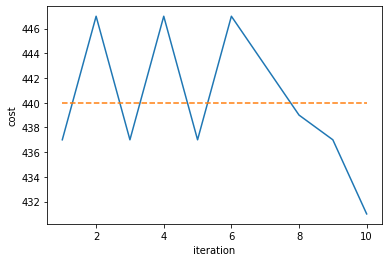

mean value:  440.2


In [37]:
plot_res(resultscp41, iters, 440)
print("mean value: ", np.mean(resultscp41))

Test SCP51

In [18]:
resultscp51 = test(testcases[1], num_iterations=200, run=10, Q=2000, num_ants=30)

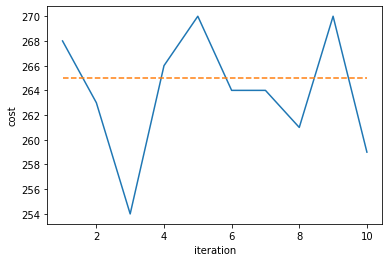

mean value:  263.9


In [39]:
plot_res(resultscp51, iters, 265)
print("mean value: ", np.mean(resultscp51))

Test SCP54

In [20]:
resultscp54 = test(testcases[2], num_iterations=200, run=10, Q=2000, num_ants=30)

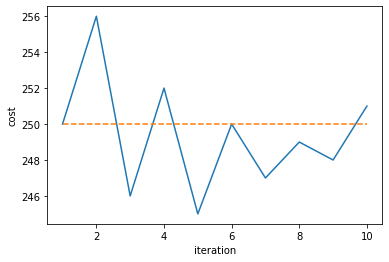

mean value:  249.4


In [41]:
plot_res(resultscp54, iters, 250)
print("mean value: ", np.mean(resultscp54))

Test SCPA2

In [22]:
resultscpa2 = test(testcases[3], num_iterations=200, run=10, Q=3000, num_ants=30)

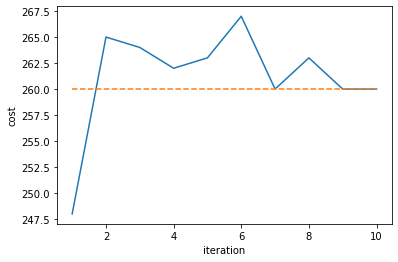

mean value:  261.2


In [43]:
plot_res(resultscpa2, iters, 260)
print("mean value: ", np.mean(resultscpa2))

Test SCPB1

In [7]:
resultscpb1 = test(testcases[4], num_iterations=200, run=10, Q=3000, num_ants=30)

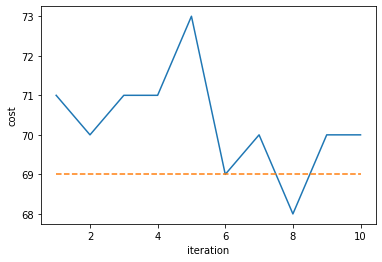

mean value:  70.3


In [50]:
plot_res(resultscpb1, iters, 69)
print("mean value: ", np.mean(resultscpb1))